## Functions and libraries 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
from classifiers import *
from sklearn.metrics import confusion_matrix

In [13]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [34]:
def feature_selection(X, y):
    model = LogisticRegression(solver='lbfgs', max_iter=300)
    models = {'logistic': model, 'RFE': RFE(model, 5), 'ridge': Ridge(alpha=1.0), 'Lasso': Lasso()}
    for k, v in models.items():
        print(k)
        fit = v.fit(X, y)
        if k == 'RFE':
            print("Num Features: %s" % (fit.n_features_))
            print("Feature Ranking: %s" % (fit.ranking_))
            for i, j in sorted(zip(fit.ranking_, X.columns), reverse=False):
                print(i,j)

        elif k == 'logistic':
            for i, j in sorted(zip(map(lambda x: round(x, 4), fit.coef_.reshape(-1)), X.columns), reverse=True):
                print(i,j)
        else:
            for i, j in sorted(zip(map(lambda x: round(x, 4), abs(fit.coef_)), X.columns), reverse=True):
                print(i,j)

## Different perspective
1. PCA
2. manual
   - encode trustLevel
   - delete 'valuePerSecond', 'scannedLineItemsPerSecond', 'lineItemVoidsPerPosition'
   - generate no. item = totalScanTimeInSeconds * scannedLineItemsPerSecond
3. automatic generation => not done

In [6]:
def code_for_test(X,y):
    """
    test code with 10-fold stratified cross validation
    parameters
    X: trainset features after generation
    y: trainset y label
    """
    evaluate_classification(X, y)

## Dataset for test
prepare different input dataset and test at 10-fold stratified cross validation set
1. X (raw data)
2. X_train_norm data (normalized)
3. X_train_norm_enc data (normalized and encode)
4. X_train_manual (manual)
5. X_train_manual_enc (manual and encode)

## Original

In [2]:
train_data = pd.read_csv('data/train.csv', sep = '|')
test_data = pd.read_csv('data/test.csv', sep = '|')
print(f'Train set has {train_data.shape[0]} entries and {train_data.shape[1]} features')
print(f'Test set has {test_data.shape[0]} entries and {test_data.shape[1]} features')

Train set has 1879 entries and 10 features
Test set has 498121 entries and 9 features


In [3]:
y = train_data['fraud']
X = train_data.drop(columns=['fraud']).astype(float)
fit_minmax = MinMaxScaler()
X_encode = pd.get_dummies(X, columns=['trustLevel'], prefix='trustLevel')
X_train_norm_enc = pd.DataFrame(fit_minmax.fit_transform(X_encode), columns=X_encode.columns, index=X_encode.index)
print(X_train_norm_enc.shape)
X_test_encode = pd.get_dummies(test_data, columns=['trustLevel'], prefix='trustLevel')
X_test_norm_enc = pd.DataFrame(fit_minmax.transform(X_test_encode), columns=X_test_encode.columns, index=X_test_encode.index)

(1879, 14)


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [4]:
# without encode
fit_minmax = MinMaxScaler()
X_train_norm = pd.DataFrame(fit_minmax.fit_transform(X), columns=X.columns, index=X.index)
print(X_train_norm.shape)
X_test_norm = pd.DataFrame(fit_minmax.transform(test_data), columns=test_data.columns, index=test_data.index)

(1879, 9)


## Manual delete and create

In [20]:
## delete correlate features
X_manual = X.assign(no_item = X.totalScanTimeInSeconds* X.scannedLineItemsPerSecond)\
                     .drop(columns=['valuePerSecond', 'scannedLineItemsPerSecond', 'lineItemVoidsPerPosition'])
X_test = test_data.assign(no_item = test_data.totalScanTimeInSeconds* test_data.scannedLineItemsPerSecond)\
                     .drop(columns=['valuePerSecond', 'scannedLineItemsPerSecond', 'lineItemVoidsPerPosition'])

fit_minmax = MinMaxScaler()

X_train_manual = pd.DataFrame(fit_minmax.fit_transform(X_manual), columns=X_manual.columns, index=X_manual.index)
X_test_manual = pd.DataFrame(fit_minmax.transform(X_test), columns=X_test.columns, index=X_test.index)
print(X_train_manual.shape)
print(X_test_manual.shape)

X_manual_encode = pd.get_dummies(X_manual, columns=['trustLevel'], prefix='trustLevel')
X_test_encode = pd.get_dummies(X_test, columns=['trustLevel'], prefix='trustLevel')

X_train_manual_enc = pd.DataFrame(fit_minmax.fit_transform(X_manual_encode), columns=X_manual_encode.columns, index=X_manual_encode.index)
X_test_manual_enc = pd.DataFrame(fit_minmax.transform(X_test_encode), columns=X_test_encode.columns, index=X_test_encode.index)
print(X_train_manual_enc.shape)
print(X_test_manual_enc.shape)


(1879, 7)
(498121, 7)
   trustLevel  totalScanTimeInSeconds  grandTotal  lineItemVoids  \
0         0.8                0.575178    0.547174       0.636364   
1         0.4                0.057955    0.273637       0.454545   
2         0.4                0.827775    0.621811       0.272727   
3         1.0                0.978130    0.923462       0.727273   
4         0.8                0.234008    0.815608       0.272727   

   scansWithoutRegistration  quantityModifications   no_item  
0                       0.0                    0.6  0.965517  
1                       0.2                    0.8  0.448276  
2                       1.0                    1.0  0.413793  
3                       0.4                    0.8  0.965517  
4                       0.7                    0.4  0.896552  
(1879, 12)
(498121, 12)


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## Cross validation test 
1. normalization => no influence
2. normalization + encode => improve 20
3. manual => improve ~ 200
4. manual + encode => get best score 225 

In [7]:
code_for_test(X_train_norm, y)

RBF SVM: test core = -520 
Logistic Regression: test core = -495 
Neural Net: test core = -510 
Random Forest: test core = -95 
AdaBoost: test core = -130 
XGBoost: test core = -80 


In [8]:
code_for_test(X_train_norm_enc, y)

RBF SVM: test core = -670 
Logistic Regression: test core = -630 
Neural Net: test core = -505 
Random Forest: test core = -80 
AdaBoost: test core = -65 
XGBoost: test core = -60 


In [9]:
code_for_test(X_train_manual, y)

RBF SVM: test core = -10 
Logistic Regression: test core = -5 
Neural Net: test core = -20 
Random Forest: test core = 95 
AdaBoost: test core = 195 
XGBoost: test core = 110 


In [24]:
code_for_test(X_train_manual_enc, y)

RBF SVM: test core = 225 
Logistic Regression: test core = 205 
Neural Net: test core = 190 
Random Forest: test core = 115 
AdaBoost: test core = 135 
XGBoost: test core = 80 


## feature selection
1. grandtotal, quantitymodification still not significant
2. remove => get better score for adaboost 235

In [44]:
feature_selection(X_train_manual_enc, y)

logistic
6.8858 no_item
3.976 trustLevel_1.0
2.7258 totalScanTimeInSeconds
1.6393 scansWithoutRegistration
1.2608 trustLevel_2.0
1.2442 lineItemVoids
0.3383 grandTotal
0.1721 quantityModifications
-1.1386 trustLevel_4.0
-1.2942 trustLevel_5.0
-1.3767 trustLevel_6.0
-1.4265 trustLevel_3.0
RFE
Num Features: 5
Feature Ranking: [1 7 2 1 8 1 1 1 3 6 5 4]
1 no_item
1 scansWithoutRegistration
1 totalScanTimeInSeconds
1 trustLevel_1.0
1 trustLevel_2.0
2 lineItemVoids
3 trustLevel_3.0
4 trustLevel_6.0
5 trustLevel_5.0
6 trustLevel_4.0
7 grandTotal
8 quantityModifications
ridge
0.2196 no_item
0.2134 trustLevel_1.0
0.0941 totalScanTimeInSeconds
0.0636 scansWithoutRegistration
0.0587 trustLevel_6.0
0.0546 trustLevel_3.0
0.0514 trustLevel_5.0
0.0461 trustLevel_4.0
0.0301 lineItemVoids
0.0176 grandTotal
0.0082 quantityModifications
0.0027 trustLevel_2.0
Lasso
0.0 trustLevel_6.0
0.0 trustLevel_5.0
0.0 trustLevel_4.0
0.0 trustLevel_3.0
0.0 trustLevel_2.0
0.0 trustLevel_1.0
0.0 totalScanTimeInSeconds
0

In [43]:
code_for_test(X_train_manual_enc.drop(columns=['grandTotal','quantityModifications']), y)

RBF SVM: test core = 115 
Logistic Regression: test core = 230 
Neural Net: test core = 210 
Random Forest: test core = 150 
AdaBoost: test core = 235 
XGBoost: test core = 100 


## test on trustLevel
1. remove => model collapse
2. only level 1, 2 => worse
3. only level 1, 2 but encode => worse 


In [31]:
X_train_notrustlevel = X_train_manual.iloc[:,:6]
# print(X_train_notrustlevel.shape)
code_for_test(X_train_notrustlevel, y)

RBF SVM: test core = -520 
Logistic Regression: test core = -540 
Neural Net: test core = -510 
Random Forest: test core = -880 
AdaBoost: test core = -1070 
XGBoost: test core = -1010 


In [32]:
X_train_trustlevel_12 = X_train_manual[X_train_manual['trustLevel']<3]
y_trust12 = y[X_train_manual['trustLevel']<3]
code_for_test(X_train_trustlevel_12, y_trust12)

RBF SVM: test core = 70 
Logistic Regression: test core = -5 
Neural Net: test core = -30 
Random Forest: test core = 120 
AdaBoost: test core = 195 
XGBoost: test core = 110 


In [39]:
X_train_trustlevel_12 = X_train_manual_enc[X_train_manual_enc['trustLevel_1.0']==1].append(X_train_manual_enc[X_train_manual_enc['trustLevel_2.0']==1]).iloc[:,:8]
y_trust12 = y[X_train_manual_enc['trustLevel_1.0']==1].append(y[X_train_manual_enc['trustLevel_2.0']==1])
code_for_test(X_train_trustlevel_12, y_trust12)

RBF SVM: test core = 130 
Logistic Regression: test core = 140 
Neural Net: test core = -120 
Random Forest: test core = 15 
AdaBoost: test core = 45 
XGBoost: test core = 150 


## PCA
1. with encode w/o encode => PCA distribution different
2. result not improve

In [35]:
from sklearn.decomposition import PCA 
pca = PCA(n_components = 'mle')
# original
X_train_PCA = pca.fit_transform(X)
X_test_PCA = pca.transform(test_data)
print('original ', pca.n_components_)

# nomalize
X_train_PCA_norm = pca.fit_transform(X_train_norm)
X_test_PCA_norm = pca.transform(X_test_norm)
print('normalize ', pca.n_components_)

# normalize encode
X_train_PCA_norm_enc = pca.fit_transform(X_train_norm_enc)
X_test_PCA_norm_enc = pca.transform(X_test_norm_enc)
print('normalize encode', pca.n_components_)

# nmanual 
X_train_PCA_manual = pca.fit_transform(X_train_manual)
X_test_PCA_manual = pca.transform(X_test_manual)
print('manual', pca.n_components_)

# nmanual encode
X_train_PCA_manual_enc = pca.fit_transform(X_train_manual_enc)
X_test_PCA_manual_enc = pca.transform(X_test_manual_enc)
print('manual encode', pca.n_components_)

# without truseLevel
X_train_PCA_notrust = pca.fit_transform(X_train_notrustlevel)
print('w/o trust', pca.n_components_)

# with trustLevel1,2
X_train_PCA_trust12 = pca.fit_transform(X_train_trustlevel_12)
print('w/ 12', pca.n_components_)


original  8
normalize  8
normalize encode 13
manual 2
manual encode 11
w/o trust 2
w/ 12 8


/usr/local/lib/python3.7/site-packages/sklearn/decomposition/pca.py:76: RuntimeWarning: divide by zero encountered in log
  pv = -np.log(v) * n_samples * (n_features - rank) / 2.
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/pca.py:87: RuntimeWarning: divide by zero encountered in double_scalars
  (1. / spectrum_[j] - 1. / spectrum_[i])) + log(n_samples)
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/pca.py:89: RuntimeWarning: invalid value encountered in double_scalars
  ll = pu + pl + pv + pp - pa / 2. - rank * log(n_samples) / 2.
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/pca.py:68: RuntimeWarning: divide by zero encountered in log
  pl = np.sum(np.log(spectrum[:rank]))
/usr/local/lib/python3.7/site-packages/sklearn/decomposition/pca.py:87: RuntimeWarning: invalid value encountered in double_scalars
  (1. / spectrum_[j] - 1. / spectrum_[i])) + log(n_samples)


Text(0.5, 1.0, 'PCA trust12')

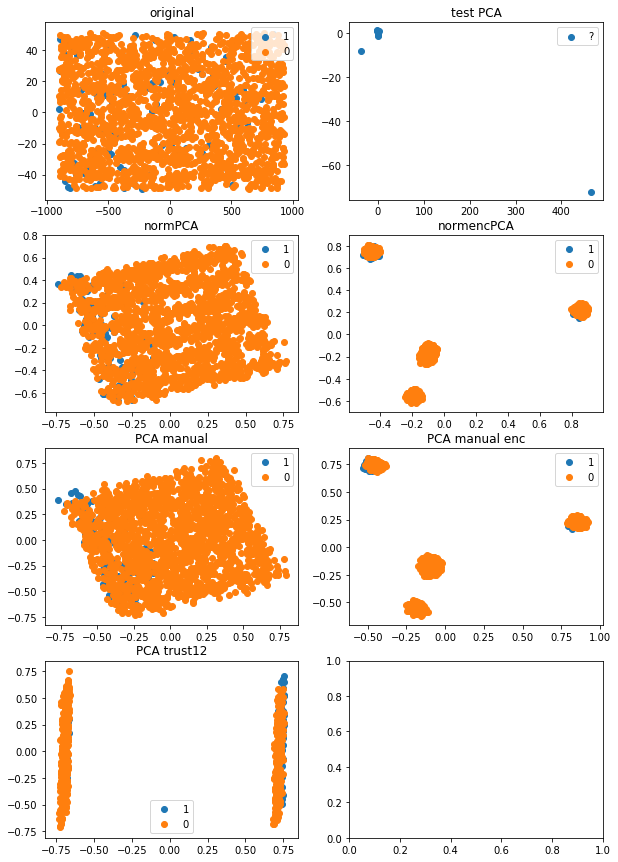

In [36]:
fig, ax = plt.subplots(4,2)
fig.set_figheight(15)
fig.set_figwidth(10)
ax[0,0].scatter(X_train_PCA[y==1,0], X_train_PCA[y==1,1], label='1')
ax[0,0].scatter(X_train_PCA[y==0,0], X_train_PCA[y==0,1], label='0')
ax[0,0].legend()
ax[0,0].set_title('original')
ax[0,1].scatter(X_test_PCA[0], X_test_PCA[1], label='?')
ax[0,1].legend()
ax[0,1].set_title('test PCA')
ax[1,0].scatter(X_train_PCA_norm[y==1,0], X_train_PCA_norm[y==1,1], label='1')
ax[1,0].scatter(X_train_PCA_norm[y==0,0], X_train_PCA_norm[y==0,1], label='0')
ax[1,0].legend()
ax[1,0].set_title('normPCA')
ax[1,1].scatter(X_train_PCA_norm_enc[y==1,0], X_train_PCA_norm_enc[y==1,1], label='1')
ax[1,1].scatter(X_train_PCA_norm_enc[y==0,0], X_train_PCA_norm_enc[y==0,1], label='0')
ax[1,1].legend()
ax[1,1].set_title('normencPCA')
ax[2,0].scatter(X_train_PCA_manual[y==1,0], X_train_PCA_manual[y==1,1], label='1')
ax[2,0].scatter(X_train_PCA_manual[y==0,0], X_train_PCA_manual[y==0,1], label='0')
ax[2,0].legend()
ax[2,0].set_title('PCA manual')
ax[2,1].scatter(X_train_PCA_manual_enc[y==1,0], X_train_PCA_manual_enc[y==1,1], label='1')
ax[2,1].scatter(X_train_PCA_manual_enc[y==0,0], X_train_PCA_manual_enc[y==0,1], label='0')
ax[2,1].legend()
ax[2,1].set_title('PCA manual enc')
# ax[2,1].scatter(X_train_PCA_notrust[y==1,0], X_train_PCA_notrust[y==1,1], label='1')
# ax[2,1].scatter(X_train_PCA_notrust[y==0,0], X_train_PCA_notrust[y==0,1], label='0')
# ax[2,1].legend()
# ax[2,1].set_title('PCA no trust')
ax[3,0].scatter(X_train_PCA_trust12[y_trust12==1,0], X_train_PCA_trust12[y_trust12==1,1], label='1')
ax[3,0].scatter(X_train_PCA_trust12[y_trust12==0,0], X_train_PCA_trust12[y_trust12==0,1], label='0')
ax[3,0].legend()
ax[3,0].set_title('PCA trust12')

In [38]:
code_for_test(X_train_PCA_manual_enc, y)

RBF SVM: test core = 225 
Logistic Regression: test core = 205 
Neural Net: test core = 190 
Random Forest: test core = 75 
AdaBoost: test core = 105 
XGBoost: test core = 115 


## Define xgboost with cost sensitive
1. better than original sgboost but worse than other algorithm 
2. best score 170

In [68]:
#!/usr/bin/python
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def logistic_obj(y_hat, dtrain, alpha=5, beta=25): # alpha for FN beta for FP
    y = dtrain.get_label()
    pred = 1. / (1. + np.exp(-y_hat))
    grad = pred * (beta + alpha*y - beta*y) - alpha*y  # alpha*(p-1)*y + beta*p*(1-y)
    hess = pred * (1 - pred) * (beta + alpha*y - beta*y)
    return grad, hess

def err_rate(pred, dtrain):
    y = dtrain.get_label()
    pred = 1. / (1. + np.exp(-pred))
    loss_fn = y*np.log(pred)
    loss_fp = (1.0 - y)*np.log(1.0 - pred)
    return 'error', np.sum(-(5*loss_fn+25*loss_fp))/len(y)




In [69]:
def cross_validate(X_train, X_test, y_train, y_test, depth, num_round):
    # load data
    d_train = xgb.DMatrix(X_train, label=y_train)
    d_val = xgb.DMatrix(X_test, label=y_test)
    # build model
    param = {'max_depth': depth, 'eta': 0.2, 'silent': 1, 'seed': 42, 'scale_pos_weight':1}
#     watchlist = [(d_val, 'eval'), (d_train, 'train')]
#     model_trn = xgb.train(param, d_train, num_round, watchlist, obj=logistic_obj, feval=err_rate)
    model_trn = xgb.train(param, d_train, num_round, obj=logistic_obj, feval=err_rate)
    # prediction
    pred = model_trn.predict(d_val) 
    pred = 1. / (1. + np.exp(-pred))
    return pred

In [70]:
def cv_cost(X,y, depth, rounds):
    cv = StratifiedKFold(n_splits=10, random_state=42)
    cost=0
    if type(X) == pd.DataFrame:
        X=X.values
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        pred = cross_validate(X_train, X_test, y_train, y_test, depth, rounds)
#         print(f' confusion matrix: cost({profit_scorer(y_test, pred>0.5)})\n {confusion_matrix(y_test, pred>0.5)}')
        cost += profit_scorer(y_test, pred>0.5)

    print(f'cost = {cost}')

In [10]:
cv_cost(X_train_norm_enc, y, 3 ,100)

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


cost = 70


In [91]:
cv_cost(X_train_PCA_manual, y, 3, 90)

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


cost = 170


In [17]:
cv_cost(X_train_PCA, y, 3, 100)

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


cost = 160
